In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [3]:
trades=pd.read_csv('historical_data.csv')
trades['timestamp']=pd.to_datetime(trades['Timestamp'],unit='ms')
trades['Date']=trades['timestamp'].dt.date


sentiment=pd.read_csv('fear_greed_index.csv',parse_dates=['date'])
sentiment.rename(columns={'classification':'Sentiment','date':'Date'},inplace=True)
sentiment['Date']=sentiment['Date'].dt.date

In [4]:
# Merge on Date
df=pd.merge(trades,sentiment[['Date','Sentiment']],on='Date',how='left')
df.dropna(subset=['Sentiment'],inplace=True)


In [5]:
# Rename and clean
columns={
    'Account':'account','Coin':'symbol','Side':'side',
    'Closed PnL':'closedPnl','Execution Price':'execution_price',
    'Size Tokens':'size_tokens'
}
df.rename(columns=columns,inplace=True)

In [6]:
for col in ['closedPnl','execution_price','size_tokens']:
    df[col]=pd.to_numeric(df[col],errors='coerce')

df['side']=df['side'].str.lower()
df['symbol']=df['symbol'].str.upper()
df['volume']=df['execution_price']*df['size_tokens']

In [7]:
#Basic Analysis: Performance by Sentiment
perf_summary=df.groupby('Sentiment')['closedPnl'].agg(['mean','median','std','count','sum'])
volume_summary=df.groupby('Sentiment')['volume'].sum()
perf_summary

,mean,median,std,count,sum
Sentiment,,,,,
Extreme Greed,0.000000,0.00000,0.000000,88,0.000000e+00
Fear,259.225977,0.00000,2678.902052,10434,2.704764e+06
Greed,-70.600067,0.00000,3703.167569,1337,-9.439229e+04
Neutral,584.592162,134.40141,1784.422654,249,1.455634e+05


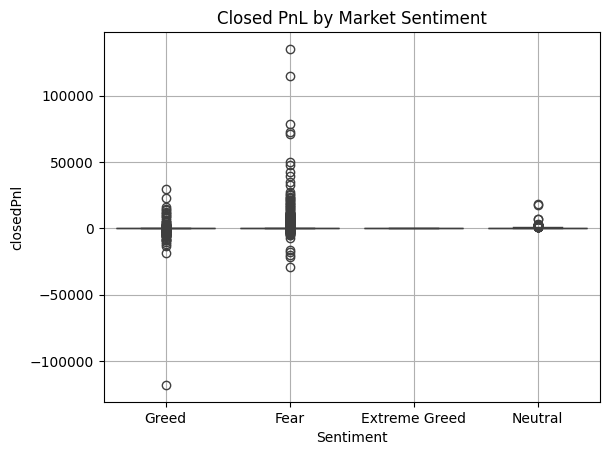

In [8]:
sns.boxplot(data=df,x='Sentiment',y='closedPnl')
plt.title('Closed PnL by Market Sentiment')
plt.grid(True)
plt.show()

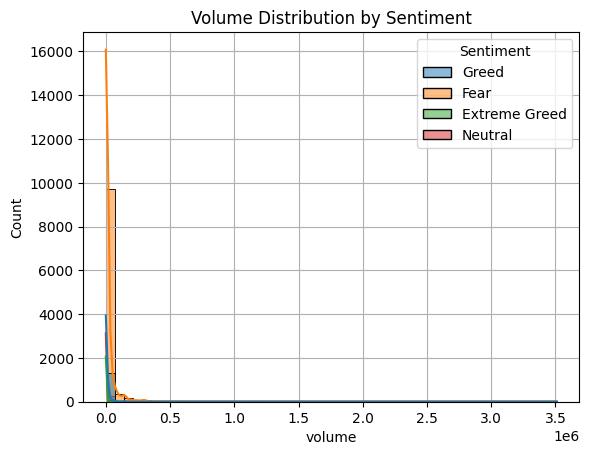

In [9]:
sns.histplot(data=df,x='volume',hue='Sentiment',bins=50,kde=True)
plt.title('Volume Distribution by Sentiment')
plt.grid(True)
plt.show()

In [10]:
#Uncover Hidden Patterns – Trader Sentiment Bias
account_perf=df.groupby(['account','Sentiment'])['closedPnl'].sum().unstack(fill_value=0)
account_perf['Bias']=np.where(account_perf['Greed']>account_perf['Fear'],'Greed','Fear')
account_perf['Total']=account_perf['Greed']+account_perf['Fear']
account_perf.sort_values('Total',ascending=False).head()

Sentiment,Extreme Greed,Fear,Greed,Neutral,Bias,Total
account,,,,,,
0x083384f897ee0f19899168e3b1bec365f52a9012,0.0,1.927736e+06,-327505.900056,0.000000,Fear,1.600230e+06
0x513b8629fe877bb581bf244e326a047b249c4ff1,0.0,4.035016e+05,0.000000,0.000000,Fear,4.035016e+05
0x72c6a4624e1dffa724e6d00d64ceae698af892a0,0.0,3.419454e+05,51737.579418,0.000000,Fear,3.936830e+05
0x430f09841d65beb3f27765503d0f850b8bce7713,0.0,2.282929e+04,160450.518105,145563.448374,Greed,1.832798e+05
0xae5eacaf9c6b9111fd53034a602c192a04e082ed,0.0,8.751751e+03,20925.513222,0.000000,Greed,2.967726e+04


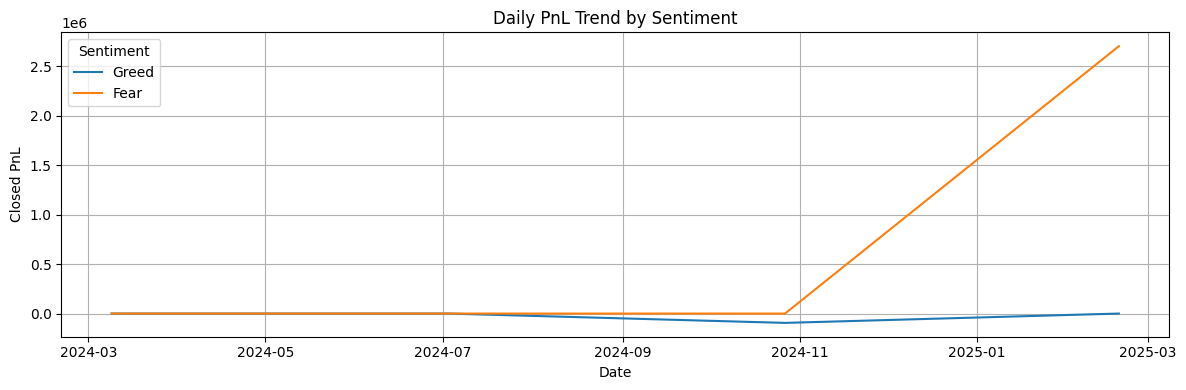

In [11]:
# PnL Trend Over Time
daily_pnl=df.groupby(['Date','Sentiment'])['closedPnl'].sum().reset_index()
pivoted=daily_pnl.pivot(index='Date',columns='Sentiment',values='closedPnl').fillna(0)
pivoted[['Greed','Fear']].plot(title='Daily PnL Trend by Sentiment',figsize=(12,4))
plt.ylabel('Closed PnL')
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
#Top Trader Sentiment Trends
top_accounts=df.groupby('account')['closedPnl'].sum().nlargest(10).index
top_account_data=df[df['account'].isin(top_accounts)]
strategic_behavior=top_account_data.groupby(['account','Sentiment'])['closedPnl'].mean().unstack()
strategic_behavior

Sentiment,Extreme Greed,Fear,Greed,Neutral
account,,,,
0x083384f897ee0f19899168e3b1bec365f52a9012,NaN,574.414696,-708.887230,NaN
0x430f09841d65beb3f27765503d0f850b8bce7713,0.0,126.829403,3731.407398,584.592162
0x513b8629fe877bb581bf244e326a047b249c4ff1,NaN,69.846226,0.000000,NaN
0x72c6a4624e1dffa724e6d00d64ceae698af892a0,NaN,364.159142,123.478710,NaN
0xae5eacaf9c6b9111fd53034a602c192a04e082ed,NaN,48.086546,110.134280,NaN


In [13]:
#K-Means Clustering: Trader Segmentation
features=df.groupby('account')[['closedPnl','volume']].sum()
scaler=StandardScaler()
scaled=scaler.fit_transform(features)
kmeans=KMeans(n_clusters=3,random_state=42).fit(scaled)
features['cluster']=kmeans.labels_
features.groupby('cluster').mean()

,closedPnl,volume
cluster,,
0,2.507345e+05,1.935750e+06
1,4.035016e+05,1.642421e+08
2,1.600230e+06,6.169726e+07


In [14]:
#Predict Trader Profitability from Sentiment
df_model=df[['side','symbol','Sentiment','volume','closedPnl']].dropna()
df_model['label']=(df_model['closedPnl']>0).astype(int)
df_model=pd.get_dummies(df_model,columns=['side','symbol','Sentiment'],drop_first=True)

X=df_model.drop(['closedPnl','label'],axis=1)
y=df_model['label']

In [15]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)
model=RandomForestClassifier(random_state=42)
model.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [16]:
y_pred=model.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1968  284]
 [ 298 1083]]
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      2252
           1       0.79      0.78      0.79      1381

    accuracy                           0.84      3633
   macro avg       0.83      0.83      0.83      3633
weighted avg       0.84      0.84      0.84      3633

